# Sheet 9

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
from torch.utils.data import TensorDataset, DataLoader

# 2) Classifier Reweighting 

(a)

In [2]:
data_LO = np.load("data09/ttbarj_LO.npy")
data_NLO = np.load("data09/ttbarj_NLO.npy")
print(data_LO.shape, data_NLO.shape)

(45115, 28) (57043, 28)


In [3]:
data = np.concatenate((data_LO, data_NLO), axis=0)
labels = np.concatenate((np.zeros(data_LO.shape[0]), np.ones(data_NLO.shape[0])), axis=0)
idx = np.random.permutation(len(data))
data = data[idx,:]
labels=labels[idx,None]

In [4]:
def preprocess(event, mean=None, std=None):
    if mean is None or std is None:
        mean = event.mean(axis=0, keepdims=True)
        std = event.std(axis=0, keepdims=True)
    event = (event - mean) / std
    return event, mean, std

def create_dataloader(data, labels, batchsize, shuffle, mean=None, std=None):
    data, mean, std = preprocess(data, mean, std)
    data = torch.tensor(data).float()
    labels = torch.tensor(labels)
    loader = DataLoader(TensorDataset(data, labels), batch_size=batchsize, shuffle=shuffle)
    return loader, mean, std

In [5]:
n1, n2 = 50000, 60000
batchsize = 512
data_trn, data_val, data_tst = data[:n1,:], data[n1:n2,:], data[n2:,:]
labels_trn, labels_val, labels_tst = labels[:n1,:], labels[n1:n2,:], labels[n2:,:]

mean, std = None, None
loader_trn, mean, std = create_dataloader(data_trn, labels_trn, batchsize, True, mean=mean, std=std)
loader_tst, mean, std = create_dataloader(data_tst, labels_tst, batchsize, False, mean=mean, std=std)
loader_val, mean, std = create_dataloader(data_val, labels_val, batchsize, False, mean=mean, std=std)

In [30]:
class Classifier(nn.Module):    
    def __init__(self, n_layers=5, n_in=28, n_hidden=128, dropout=0.1):
        super().__init__()
        
        layers = []
        layers.append(nn.Linear(n_in, n_hidden))
        layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(dropout))
        for _ in range(n_layers):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(n_hidden, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [31]:
def batch_loss(data):
    x, y = data
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    return loss

def train_epoch(loader, losses):
    model.train()
    for data in loader:
        loss = batch_loss(data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

def val_epoch(loader):
    losses = []
    model.eval()
    with torch.no_grad():
        for data in loader:
            loss = batch_loss(data)
            losses.append(loss.item())
    return np.mean(losses)

In [32]:
model = Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

nepochs = 200
patience = 10
min_val_loss = 1e20
es_epochs = 0
losses, val_losses = [], []
for i in range(nepochs):
    train_epoch(loader_trn, losses)
    
    val_loss = val_epoch(loader_val)
    val_losses.append(val_loss)
    if i%10==0:
        print(f"{i}/{nepochs}\t {val_loss:.4e}")
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        es_epochs = 0
    else:
        es_epochs += 1
        if es_epochs == patience:
            print(f"Early stopping in epoch {i} after no improvement in {es_epochs} epochs")
            break

0/200	 6.8329e-01
10/200	 6.5983e-01
20/200	 6.5707e-01
30/200	 6.5547e-01
40/200	 6.5549e-01
Early stopping in epoch 40 after no improvement in 10 epochs


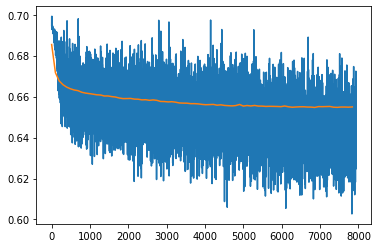

In [21]:
losses, val_losses = np.array(losses), np.array(val_losses)
x = len(val_losses)
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(val_losses))*len(loader_trn), val_losses)
plt.show()

In [22]:
model.eval()
truth, pred = [], []
with torch.no_grad():
    for (x, y) in loader_tst:
        y_pred = model(x)
        truth.append(y.flatten().numpy())
        pred.append(y_pred.flatten().numpy())
pred = np.concatenate(pred)
truth = np.concatenate(truth)
print(pred.shape, truth.shape)

(42158,) (42158,)


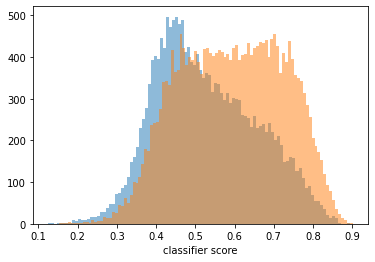

In [23]:
pred_sig = 1/ (1+np.exp(-pred))
plt.hist(pred_sig[truth==0], bins=100, alpha=.5)
plt.hist(pred_sig[truth==1], bins=100, alpha=.5)
plt.xlabel("classifier score")
plt.show()

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, th = roc_curve(truth, pred)
auc_score = roc_auc_score(truth, pred)
print(f"AUC = {auc_score:.2f}")

AUC = 0.64


(b)

We have $$w_\mathrm{LO\to NLO} = \frac{p_\mathrm{NLO}}{p_\mathrm{LO}} = \frac{D}{1-D}$$ for a classifier trained on a BCE loss with label 1 for NLO events. One can understand this from $$p_\mathrm{NLO} = \frac{p_\mathrm{NLO}}{p_\mathrm{LO}}p_\mathrm{LO} = w_\mathrm{LO\to NLO} p_\mathrm{LO}.$$

(c)

In [25]:
weights = np.exp(pred)

In [26]:
def get_pt(particle):
    return np.sqrt(particle[:,1]**2 + particle[:,2]**2)
def get_mass(particle):
    return np.sqrt(particle[:,0]**2 - np.sum(particle[:,1:]**2, axis=-1))
def get_top1(event):
    return event[:,:4] + event[:,4:8] + event[:,8:12]

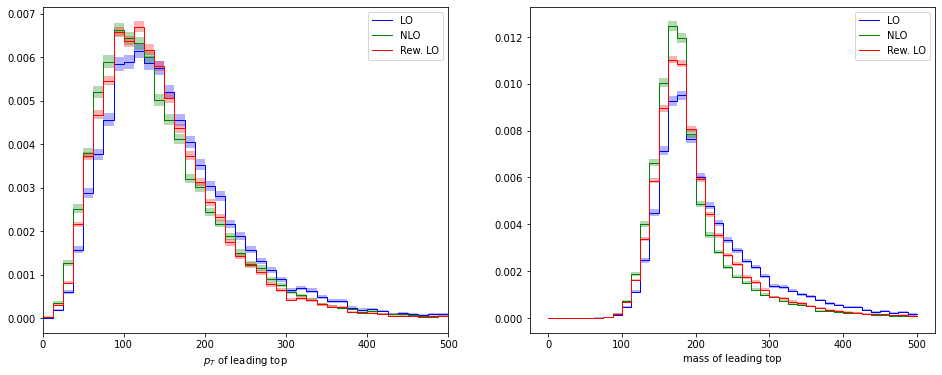

In [28]:
test_LO = data_tst[labels_tst[:,0]==0]
test_NLO = data_tst[labels_tst[:,0]==1]

pt_top1_LO = get_pt(get_top1(test_LO))
pt_top1_NLO = get_pt(get_top1(test_NLO))

mass_top1_LO = get_mass(get_top1(test_LO))
mass_top1_NLO = get_mass(get_top1(test_NLO))

weights_LOtoNLO = weights[labels_tst[:,0]==0]

def plot_hist(ax, data, label, color, bins=40, weights=None, xrange=None):
    dup_last = lambda a: np.append(a, a[-1])
    
    hist, bins = np.histogram(data, bins, weights=weights, range=xrange)
    hist_raw, _ = np.histogram(data, bins)
    hist_err = np.sqrt(hist_raw) # correct uncertainties for weighted events
    integral = np.sum((bins[1:] - bins[:-1])*hist)
    scale = 1/integral
    
    ax.step(bins, dup_last(hist)*scale, label=label, linewidth=1.0, where="post", color=color)
    ax.fill_between(bins, dup_last(hist+hist_err)*scale, dup_last(hist-hist_err)*scale,
                   facecolor=color, step="post", alpha=.3)
    return bins
    
fig, axs = plt.subplots(1,2,figsize=(16,6))

xrange = (0, 500)
bins = plot_hist(axs[0], pt_top1_LO, label="LO", color="b", bins=40, weights=None, xrange=xrange)
plot_hist(axs[0], pt_top1_NLO, label="NLO", color="g", bins=bins, weights=None)
plot_hist(axs[0], pt_top1_LO, label="Rew. LO", color="r", bins=bins, weights=weights_LOtoNLO)
axs[0].legend()
axs[0].set_xlim(xrange)
axs[0].set_xlabel(r"$p_T$ of leading top")

xrange = (0,500)
bins = plot_hist(axs[1], mass_top1_LO, label="LO", color="b", bins=40, weights=None, xrange=xrange)
plot_hist(axs[1], mass_top1_NLO, label="NLO", color="g", bins=bins, weights=None)
plot_hist(axs[1], mass_top1_LO, label="Rew. LO", color="r", bins=bins, weights=weights_LOtoNLO)
axs[1].legend()
axs[1].set_xlabel(r"mass of leading top")

plt.show()

# 3) Event Generation with a Variational Autoencoder

In [ ]:
# download data to folder data09
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data09"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-11-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data09

In [2]:
data_trn = np.load("data09/tutorial-11-data/dy_trn_data.npy")
data_tst = np.load("data09/tutorial-11-data/dy_tst_data.npy")
data_val = np.load("data09/tutorial-11-data/dy_val_data.npy")
print(data_trn.shape, data_tst.shape, data_val.shape)

(1384081, 8) (296588, 8) (296588, 8)


In [3]:
def get_mass(particle):
    return np.sqrt(np.clip(particle[:,0]**2 - np.sum(particle[:,1:]**2, axis=-1), 0, None))

def get_pt(particle):
    return np.sqrt(particle[:,1]**2 + particle[:,2]**2)

def get_eta(particle):
    p_absolute = np.sqrt(np.sum(particle[:,1:]**2, axis=-1))
    return np.arctanh(particle[:,3] / p_absolute)

def get_phi(particle):
    return np.arctan2(particle[:,2], particle[:,1])

def get_pt_phi_eta_mass(particle):
    pt = get_pt(particle)
    phi = get_phi(particle)
    eta = get_eta(particle)
    mass = get_mass(particle)
    return np.stack((pt, phi, eta, mass), axis=-1)

In [4]:
def preprocess(events, mean=None, std=None):
    if mean is None or std is None:
        mean = events.mean(axis=0, keepdims=True)
        std = events.std(axis=0, keepdims=True)
    events_prepd = (events - mean) / std
    events_prepd = torch.tensor(events_prepd).float()
    return events_prepd, mean, std
def undo_preprocess(events, mean, std):
    return events * std + mean

In [5]:
data_trn_prepd, mean, std = preprocess(data_trn)
data_tst_prepd, _, _ = preprocess(data_tst, mean, std)
data_val_prepd, _, _ = preprocess(data_val, mean, std)

dataset_trn = TensorDataset((data_trn_prepd))
dataset_tst = TensorDataset((data_tst_prepd))
dataset_val = TensorDataset((data_val_prepd))

batchsize = 256
dataloader_trn = DataLoader(dataset_trn, batch_size=batchsize, shuffle=True)
dataloader_tst = DataLoader(dataset_tst, batch_size=batchsize, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, shuffle=False)

(b)

In [23]:
class VAE(nn.Module):
    def __init__(self, n_layers=3, n_data=8, n_latent=6, n_hidden=32):
        super().__init__()
        self.n_latent = n_latent
        
        # construct encoder
        encoder = []
        encoder.append(nn.Linear(n_data, n_hidden))
        encoder.append(nn.ReLU())
        for _ in range(n_layers):
            encoder.append(nn.Linear(n_hidden, n_hidden))
            encoder.append(nn.ReLU())
        encoder.append(nn.Linear(n_hidden, 2*n_latent))
        self.encoder = nn.Sequential(*encoder)
        
        # construct decoder
        decoder = []
        decoder.append(nn.Linear(n_latent, n_hidden))
        decoder.append(nn.ReLU())
        for _ in range(n_layers):
            decoder.append(nn.Linear(n_hidden, n_hidden))
            decoder.append(nn.ReLU())
        decoder.append(nn.Linear(n_hidden, n_data))
        self.decoder = nn.Sequential(*decoder)
    
    def encode(self, x):
        x = self.encoder(x)
        
        # seperate mu and logsigma2
        x = x.reshape(x.shape[0], x.shape[1]//2, 2)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def neg_log_prob(self, x):
        # call encoder
        latent = self.encode(x)
        mu, log_sigma2 = latent[...,0], latent[...,1]
        z = mu + (log_sigma2/2).exp() * torch.randn_like(mu)
        
        # call decoder
        xprime = self.decode(z)
        
        # evaluate loss
        loss_reco = torch.mean( (x - xprime)**2 )
        loss_kl_expression = 0.5 * (- log_sigma2
            + mu**2 + log_sigma2.exp() - 1)
        loss_kl = loss_kl_expression.mean()
        loss = loss_reco + loss_kl
        return loss, loss_reco, loss_kl
    
    def sample(self, num_samples):
        self.eval()
        with torch.no_grad():
            latent = torch.randn(num_samples, self.n_latent)
            x = self.decode(latent)
        return x

In [19]:
def batch_loss(model, x, loss_dict):
    loss, loss_reco, loss_kl = model.neg_log_prob(x)
    if loss_dict is not None:
        loss_dict["full"].append(loss.item())
        loss_dict["reco"].append(loss_reco.item())
        loss_dict["kl"].append(loss_kl.item())
    return loss, loss_dict

def train_epoch(model, loader, loss_dict):
    model.train()
    for (x,) in loader:
        loss, loss_dict = batch_loss(model, x, loss_dict)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_dict

def val_epoch(model, loader):
    losses = []
    model.eval()
    with torch.no_grad():
        for (x,) in loader:
            loss, _ = batch_loss(model, x, loss_dict=None)
            losses.append(loss.item())
    return np.mean(losses)

In [38]:
model = VAE(n_data=8, n_latent=3, n_hidden=32, n_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
nepochs = 5
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters} parameters")
#print(model)

loss_dict = {"full": [], "reco": [], "kl": []}
for epoch in range(nepochs):
    loss_dict = train_epoch(model, dataloader_trn, loss_dict)
    
    val_loss = val_epoch(model, dataloader_val)
    print(f"{epoch}/{nepochs}\t {val_loss}")

Model has 7214 parameters
0/5	 0.9334418510341562
1/5	 0.927622734728921
2/5	 0.9278918518086154
3/5	 0.9278423703879092
4/5	 0.9303914506030144


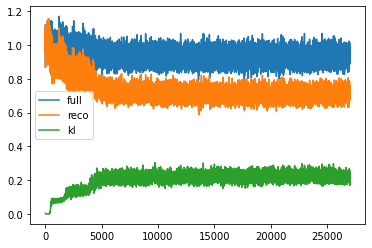

In [39]:
for label in ["full", "reco", "kl"]:
    plt.plot(loss_dict[label], label=label)
#plt.yscale("log")
plt.legend()
plt.show()

In [40]:
generated_prepd = model.sample(data_tst_prepd.shape[0]).numpy()
generated = undo_preprocess(generated_prepd, mean, std)
print(generated_prepd)

[[-0.20004544  0.67916006 -0.03454665 ... -0.6807058   0.03439604
  -0.05895346]
 [-0.15853882 -0.8133261   0.03067731 ...  0.8116257  -0.01894344
   0.02953804]
 [-0.1960099  -0.6661998   0.02033644 ...  0.66359997 -0.0119957
   0.0420984 ]
 ...
 [ 2.07479    -0.22165343  0.09462719 ...  0.20836392 -0.07764564
  -2.048684  ]
 [-0.22591409  0.44485763 -0.02404628 ... -0.4443194   0.02257164
  -0.05037335]
 [ 0.00399832  0.98365456 -0.04516397 ... -0.985693    0.04502857
   0.15736723]]


In [41]:
components_Eppp = ["E [GeV]", "px [GeV]", "py [GeV]", "pz [GeV]"]
components_jetcoordinates = ["pt [GeV]", "phi", "eta", "mass [GeV]"]
def plot(truth, generated, bins=20):
    fig, axs = plt.subplots(4,4, figsize=(15,15))
    
    # plot (E, px, py, pz) for both particles
    for iparticle in range(2):
        for icomponent in range(4):
            ax = axs[iparticle, icomponent]
            xlabel = f"{components_Eppp[icomponent]} of particle {iparticle+1}"
            i = iparticle*4 + icomponent
            
            bins_local = bins
            _, bins_local, _ = ax.hist(truth[:,i], bins=bins_local, alpha=.5, label="truth", density=True)
            ax.hist(generated[:,i], bins=bins_local, alpha=.5, label="model", density=True)
            ax.legend()
            ax.set_xlabel(xlabel)
    
    # plot (pt phi eta mass) for both particles
    truth = np.concatenate((get_pt_phi_eta_mass(truth[:,:4]), 
                            get_pt_phi_eta_mass(truth[:,4:])), axis=-1)
    generated = np.concatenate((get_pt_phi_eta_mass(generated[:,:4]), 
                                get_pt_phi_eta_mass(generated[:,4:])), axis=-1)
    for iparticle in range(2):
        for icomponent in range(4):
            ax = axs[2+iparticle, icomponent]
            xlabel = f"{components_jetcoordinates[icomponent]} of particle {iparticle+1}"
            i = iparticle*4 + icomponent
            
            bins_local = bins
            _, bins_local, _ = ax.hist(truth[:,i], bins=bins_local, alpha=.5, label="truth", density=True)
            ax.hist(generated[:,i], bins=bins_local, alpha=.5, label="model", density=True)
            ax.legend()
            ax.set_xlabel(xlabel)

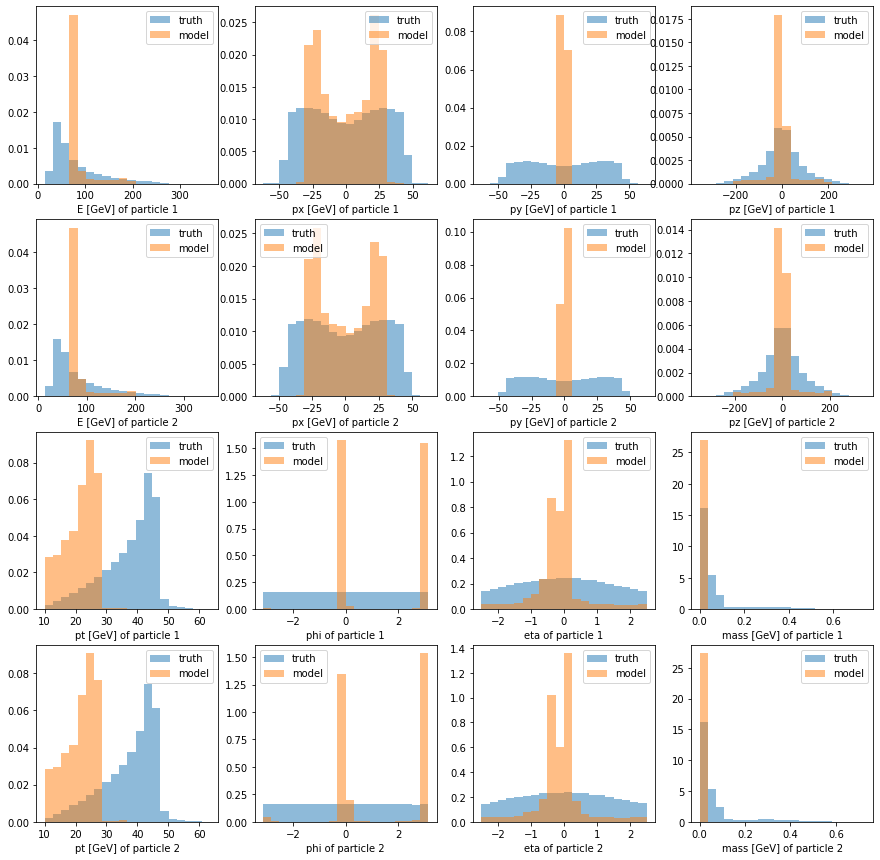

In [42]:
plot(data_tst, generated)

Comments on the results
- Model struggles hard to map out non-gaussian features
- Bottleneck size 3 gives the best results, as expected
- Increasing the network size would help, but does not make it perfect

(c)

Text(0.5, 0, '$m_{\\mu,2}$ [GeV]')

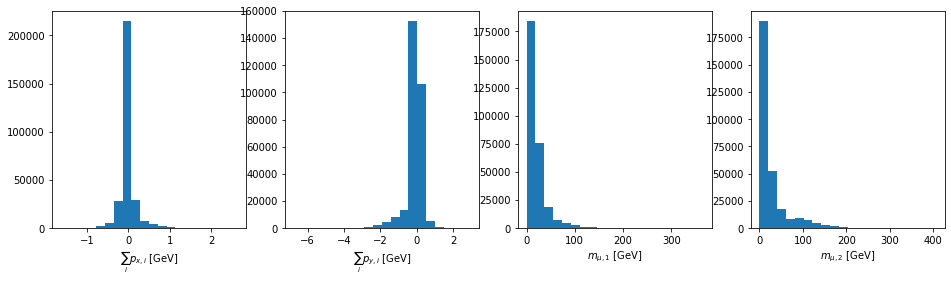

In [73]:
fig, axs = plt.subplots(1,4, figsize=(16,4))

axs[0].hist(generated[:,1]+generated[:,5], bins=20)
axs[0].set_xlabel(r"$\sum_i p_{x,i}$ [GeV]")

axs[1].hist(generated[:,2]+generated[:,6], bins=20)
axs[1].set_xlabel(r"$\sum_i p_{y,i}$ [GeV]")

axs[2].hist(get_mass(generated[:,:4]), bins=20)
axs[2].set_xlabel(r"$m_{\mu,1}$ [GeV]")
            
axs[3].hist(get_mass(generated[:,4:]), bins=20)
axs[3].set_xlabel(r"$m_{\mu,2}$ [GeV]")

Observations
- Momentum is not conserved exactly, but to a surprisingly good degree when comparing to the other distributions. 
- Muon mass is nowhere near zero, the model totally fails to learn this feature

(e)

In [48]:
# cuts in the dataset
get_pt(data_tst[:,:4]).min(), get_pt(data_tst[:,4:]).min() # pt cuts
get_eta(data_tst[:,:4]).min(), get_eta(data_tst[:,:4]).max()

eta_cut = 2.5 + 1e-5 # should be 2.5 but one event is weird
pt_cut = 10.

In [51]:
def preprocess2(events, mean=None, std=None):
    particle1, particle2 = events[:,:4], events[:,4:]
    events_jetcoordinates = np.stack((get_pt(particle1), get_phi(particle1), get_eta(particle1), get_mass(particle1), get_pt(particle2), get_phi(particle2), get_eta(particle2), get_mass(particle2)), axis=-1)
    events_reduced = events_jetcoordinates[:,[0,2,6]]
    
    events_reduced[:,0] = np.log(events_reduced[:,0] - pt_cut)
    events_reduced[:,1:] = np.arctanh(events_reduced[:,1:] / eta_cut)
    
    if mean is None or std is None:
        mean = events_reduced.mean(axis=0)
        std = events_reduced.std(axis=0)
    events_reduced = (events_reduced - mean) / std
    
    assert np.isfinite(events_reduced).all()
    events_reduced = torch.tensor(events_reduced).float()
    return events_reduced, mean, std
    
def undo_preprocess2(events_reduced, mean, std):
    events_reduced = events_reduced * std + mean
    
    events_reduced[:,0] = np.exp(events_reduced[:,0]) + pt_cut
    events_reduced[:,[1,2]] = np.tanh(events_reduced[:,[1,2]]) * eta_cut
    
    pt1, eta1, eta2 = events_reduced.T
    phi1 = np.random.uniform(0, 2*np.pi, events_reduced.shape[0])
    mass1, mass2 = np.ones((2, events_reduced.shape[0])) * 0.105
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    e1 = np.sqrt(mass1**2 + px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pt2 = pt1
    pz2 = pt2 * np.sinh(eta2)
    e2 = np.sqrt(mass2**2 + px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

torch.Size([296588, 3])
(296588, 8)


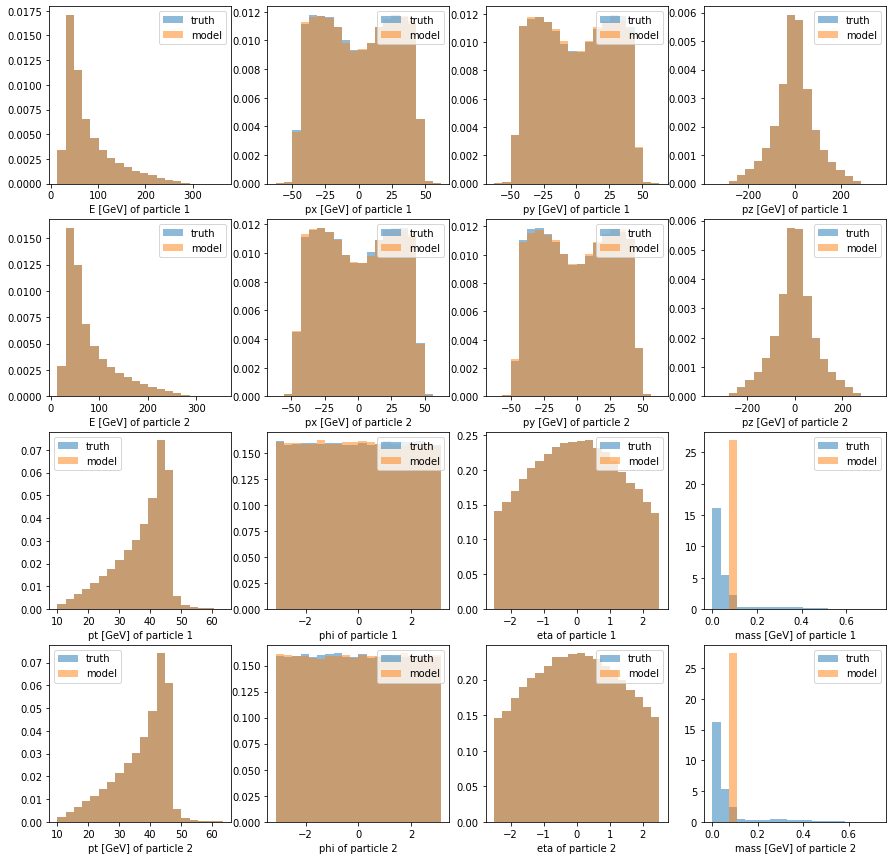

In [52]:
# check that preprocess2 and undo_preprocess2 are invertibles of each other

data_tst_prepd2, mean, std = preprocess2(data_tst)
print(data_tst_prepd2.shape)

data_tst_check = undo_preprocess2(data_tst_prepd2.numpy(), mean, std)
print(data_tst_check.shape)

plot(data_tst, data_tst_check)

Properties of the preprocessing
- Start by moving from 4-momenta to jet coordinates ($p_T$, $\phi$, $\eta$, $m$)
- Extract the minimal set of momentum components $p_{T,1}, \eta_1, \eta_2$. The masses are fixed by on-shell-conditions. The setup is spherically symmetric around the $z$-axis, making one of $\phi_1, \phi_2$ independent. Finally, the other angle and one transverse momentum are fixed by momentum conservation in the transverse plane. 
- Enforce the cuts $p_T>10 GeV, |\eta |<2.5$ by appropriate transformations
- Apply a standard rescaling to the remaining objects

The preprocessed objects have a gaussian structure

In [53]:
from torch.utils.data import TensorDataset, DataLoader

data_trn_prepd2, mean2, std2 = preprocess2(data_trn)
data_tst_prepd2, _, _ = preprocess2(data_tst, mean2, std2)
data_val_prepd2, _, _ = preprocess2(data_val, mean2, std2)

dataset_trn = TensorDataset((data_trn_prepd2))
dataset_tst = TensorDataset((data_tst_prepd2))
dataset_val = TensorDataset((data_val_prepd2))

batchsize = 256
dataloader_trn = DataLoader(dataset_trn, batch_size=batchsize, shuffle=True)
dataloader_tst = DataLoader(dataset_tst, batch_size=batchsize, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, shuffle=False)

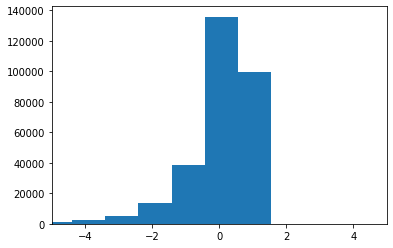

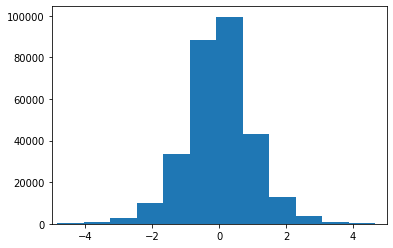

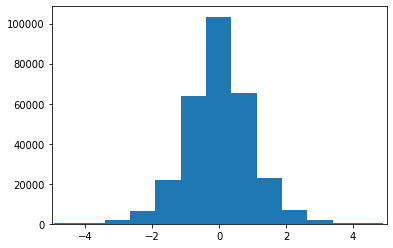

In [54]:
for i in range(3):
    plt.hist(data_tst_prepd2[:,i], bins=20)
    plt.xlim(-5, 5)
    plt.show()

In [55]:
model2 = VAE(n_data=3, n_latent=3, n_hidden=32, n_layers=3) # n_data=n_latent does not really make sense
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
nepochs = 5
total_parameters = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Model2 has {total_parameters} parameters")
#print(model2)

loss_dict = {"full": [], "reco": [], "kl": []}
for epoch in range(nepochs):
    loss_dict = train_epoch(model2, dataloader_trn, loss_dict)
    
    val_loss = val_epoch(model2, dataloader_val)
    print(f"{epoch}/{nepochs}\t {val_loss}")

Model2 has 6889 parameters
0/5	 0.7256777371899438
1/5	 0.7203173936699052
2/5	 0.7195470017847879
3/5	 0.717999423959319
4/5	 0.7154773598194534


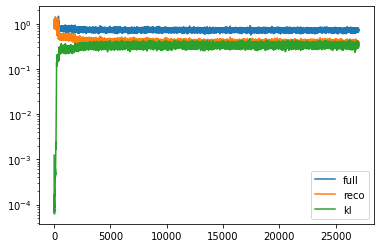

In [56]:
for label in ["full", "reco", "kl"]:
    plt.plot(loss_dict[label], label=label)
plt.yscale("log")
plt.legend()
plt.show()

In [57]:
generated_prepd2 = model2.sample(data_tst_prepd.shape[0]).numpy()
print(generated_prepd2.shape)
generated2 = undo_preprocess2(generated_prepd2, mean, std)

(296588, 3)


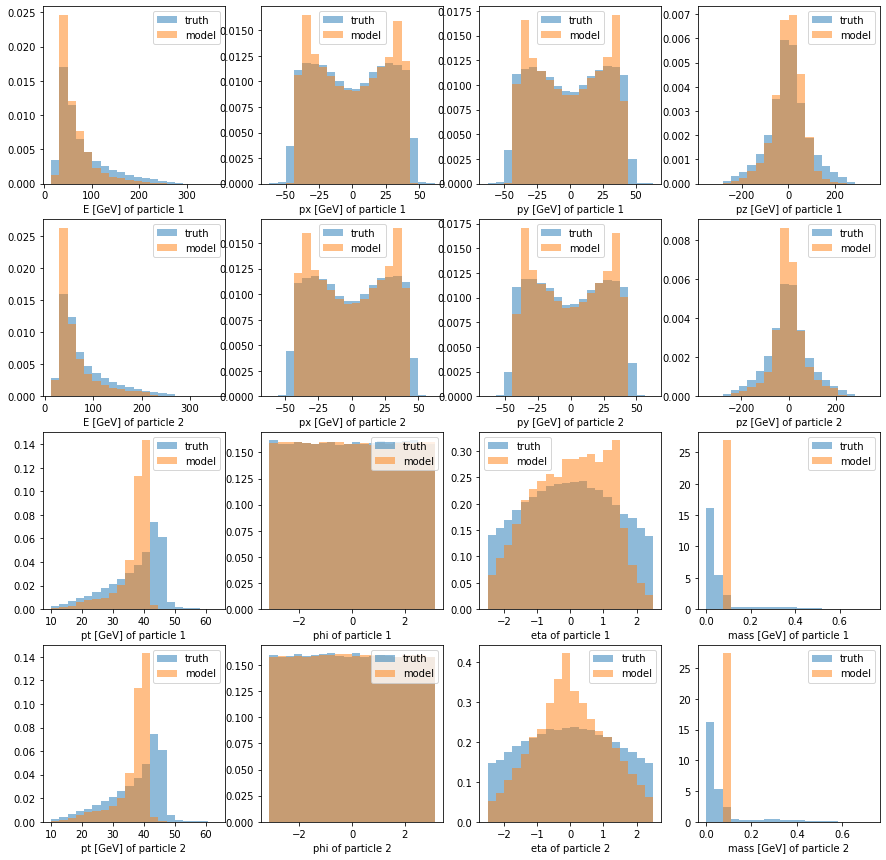

In [58]:
plot(data_tst, generated2)

Observations
- Removing redundant degrees of freedom helped, but did not make it perfect

(f)

The original motivation for testing a VAE on this problem was that it can extract the independent phase space directions, as the phase space is strongly constrained by symmetries. However, we can also do this manually with an appropriate preprocessing. After reducing the phase space to the independent components, we would have to train a VAE without a bottleneck. But this is pointless, because we lost the original motivation for trying a VAE.

Generative networks without a bottleneck are for example GANs, normalizing flows and diffusion models. Instead of explicitly learning a lower-dimensional latent space, they build up an internal representation of the phase space which is however not constrained by our manual hyperparameter choice.

VAEs are useful for generation tasks where the target space is high-dimensional, but the information of an generated object can be condensed into a much lower-dimensional space. Examples for such tasks are detector simulation and more generally image generation. 